<a href="https://colab.research.google.com/github/vsancnaj/anomaly_detection_thesis/blob/main/Final_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import os
import matplotlib.pyplot as plt
import h5py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import *
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis/csv/all_velocities3.csv')

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Thesis/csv/test1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Thesis/csv/test2.csv')

# Prepare Data

In [ ]:
def create_new_cols(df):
  # -- Create new columns to save new numpy arrays
  df['Past Velocity'] = 0
  df['Past Velocity'] = df['Past Velocity'].astype(object)
  df['Future Velocity'] = 0
  #in order to save as numpy not string # -- BY default pandas saves as string
  df['Future Velocity'] = df['Future Velocity'].astype(object) 
  # -- with astype.(object) we tell Pandas to save the variable as the type of the original input
  return df

In [ ]:
df = create_new_cols(df)
df1 = create_new_cols(df1)
df2 = create_new_cols(df2)

In [ ]:
def concatenate_cols(df):
  for index, row in df.iterrows():
    # concatenate X and Y columns
    x_arr = np.fromstring(row['X Velocities'][1:-1],sep=' ') 

    y_arr = np.fromstring(row['Y Velocities'][1:-1],sep=' ') 
    new_row = np.concatenate((x_arr, y_arr),axis=None) 
    
    # create past column
    df.at[index,'Past Velocity'] = new_row
    # create future column
    if index > 0:
      df.at[index-1,'Future Velocity'] = df.at[index,'Past Velocity']
  return df

In [ ]:
df = concatenate_cols(df)
df1 = concatenate_cols(df1)
df2 = concatenate_cols(df2)

In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		# seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
def create_sequences(df):
  #define input sequence
  in_seq1 = df.at[0,'Past Velocity']
  in_seq2 = df.at[1,'Past Velocity']
  out_seq = df.at[1,'Future Velocity']
  # convert to [rows, columns] structure
  in_seq1 = in_seq1.reshape((len(in_seq1), 1))
  in_seq2 = in_seq2.reshape((len(in_seq2), 1))
  out_seq = out_seq.reshape((len(out_seq), 1))
  # horizontally stack columns
  dataset = hstack((in_seq1, in_seq2, out_seq))
  # normalize
  scaler = preprocessing.MinMaxScaler()
  d = scaler.fit_transform(dataset)
  # choose a number of time steps
  n_steps_in = 5
  n_steps_out = 1
  # convert into input/output
  X, y = split_sequences(d, n_steps_in, n_steps_out) 
  print(X.shape, y.shape)
  #summarize the data
  # for i in range(len(X)):
  #        print(X[i], y[i])
  return n_steps_in, n_steps_out, X, y

In [ ]:
n_steps_in, n_steps_out, X , y = create_sequences(df)
_, _, X_d1, y_d1 = create_sequences(df1)
_, _, X_d2, y_d2 = create_sequences(df2)

(55, 5, 3) (55, 1, 3)
(55, 5, 3) (55, 1, 3)
(55, 5, 3) (55, 1, 3)


# Parameters

In [ ]:
n_features = X.shape[2]

In [ ]:
# parameters
test_size = 0.2
number_of_epoches = 50
#number_of_epoches = 1000
batches = 100

# Train - Test split

In [ ]:
def splitting_test_train(X, y, test_size):
  # train and testing split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

  # print shape
  print("Shapes: ",X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = splitting_test_train(X, y, test_size)

Shapes:  (44, 5, 3) (11, 5, 3) (44, 1, 3) (11, 1, 3)


In [ ]:
X_dummy1, X_dtest1, y_dummy1, y_dtest1 = splitting_test_train(X_d1, y_d1, test_size=0.98)
X_dummy2, X_dtest2, y_dummy2, y_dtest2 = splitting_test_train(X_d2, y_d2, test_size=0.98)

Shapes:  (1, 5, 3) (54, 5, 3) (1, 1, 3) (54, 1, 3)
Shapes:  (1, 5, 3) (54, 5, 3) (1, 1, 3) (54, 1, 3)


# LSTM

In [ ]:
# define model 4
model = Sequential()
model.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(10, activation='relu'))
model.add(Dense(n_features))

In [ ]:
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 10)             560       
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 1,433
Trainable params: 1,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model
history = model.fit(X_train, y_train, validation_split=0.3 ,batch_size=batches, epochs=number_of_epoches, verbose=0)

# Graphs

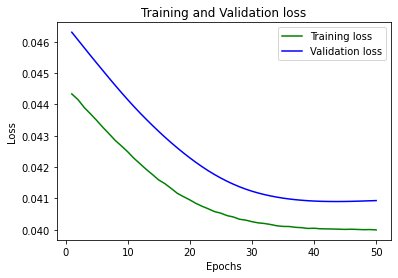

In [ ]:
#  Training and Validation Loss
# optimization learning curves
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,number_of_epoches+1)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

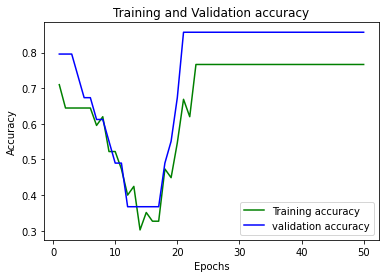

In [ ]:
#  Training and Validation Accuracy
#performance learning curves
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,number_of_epoches+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation

In [ ]:
def model_evaluate(X_train, X_test, y_train, y_test):
  # evaluate the model
  _, train_acc = model.evaluate(X_train, y_train, verbose=0)
  _, test_acc = model.evaluate(X_test, y_test, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
  return train_acc, test_acc

In [ ]:
train_acc, test_acc = model_evaluate(X_train, X_test, y_train, y_test)

Train: 0.788, Test: 0.818


In [ ]:
train_ac, test_acc = model_evaluate(X_dummy1, X_dtest1, y_dummy1, y_dtest1)
train_ac, test_acc = model_evaluate(X_dummy2, X_dtest2, y_dummy2, y_dtest2)

Train: 1.000, Test: 0.643
Train: 1.000, Test: 0.507


In [ ]:
y_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = (np.abs(y_train_pred-y_train)).mean(axis=1)
#print(train_mae_loss)
y_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = (np.abs(y_test_pred-y_test)).mean(axis=1)
#print(test_mae_loss)

In [ ]:
# Dummy 1
y_train_pred1 = model.predict(X_dummy1, verbose=0)
train_mae_loss1 = (np.abs(y_train_pred1-y_dummy1)).mean(axis=1)
#print(train_mae_loss)
y_test_pred1 = model.predict(X_dtest1, verbose=0)
test_mae_loss1 = (np.abs(y_test_pred1-y_dtest1)).mean(axis=1)
#print(test_mae_loss)

In [ ]:
# Dummy 2
y_train_pred2 = model.predict(X_dummy2, verbose=0)
train_mae_loss2 = (np.abs(y_train_pred2-y_dummy2)).mean(axis=1)
#print(train_mae_loss)
y_test_pred2 = model.predict(X_dtest2, verbose=0)
test_mae_loss2 = (np.abs(y_test_pred2-y_dtest2)).mean(axis=1)
#print(test_mae_loss)

# Anomaly Detection

In [ ]:
def find_limits_anomalies(data):
    #Based on this formula X = µ  ± Zσ

    # Set upper and lower limit to 3 standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 2
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    print(lower_limit)
    print(upper_limit)

    return lower_limit,upper_limit

In [ ]:
# get the limits from the trained data
#lower, upper = find_limits_anomalies(train_mae_loss)
# mae
lower, upper = find_limits_anomalies(y_train_pred)

0.04238113388419151
0.09522830322384834


In [ ]:
def find_anomalies(data_to_test, lower, upper):

    data_mean = np.mean(data_to_test)

    # See your new mean
    for new_data_mean in data_to_test:
        if new_data_mean.max() > upper or new_data_mean.min() < lower:
            #anomalies.append(new_data_mean)
            print("There is an anomaly present")

    #return anomalies

In [ ]:
#new_input 1
find_anomalies(y_test_pred1,lower,upper)
#find_anomalies(test_mae_loss1,lower,upper)

There is an anomaly present
There is an anomaly present
There is an anomaly present
There is an anomaly present


In [ ]:
#new_input 2
find_anomalies(y_test_pred2,lower,upper)
#find_anomalies(test_mae_loss2,lower,upper)

There is an anomaly present
There is an anomaly present
There is an anomaly present
There is an anomaly present


# Save Model

In [ ]:
# save model to single file
model.save('/content/drive/MyDrive/Thesis/models/lstm_model2.h5')

# how to load model
#model = load_model('lstm_model.h5')